In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import StackingRegressor

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore") #, category=ConvergenceWarning

# Model types
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import LocalOutlierFactor 
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline # For setting up pipeline
from sklearn.pipeline import make_pipeline

import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict

import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict

In [265]:
# Load data
df=pd.read_csv('C:/Users/sarahann.USERS/Desktop/code/NIR_model/shantha_emsc.csv')

#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html
lof = LocalOutlierFactor()
yhat2 = lof.fit_predict(df)
#print(yhat2)
yhat2.shape
mask = yhat2 != -1
df2 = df[mask]
#print(df2)
df2.shape

X = df2.iloc[:, 1:]
# y = target values, last column of the data frame
y = df2.iloc[:, 0]

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X)

selector = SelectFromModel(estimator=Ridge(random_state=23)).fit(X, y)
selector.estimator_.coef_

t=selector.threshold_
print(t)
selector.get_support()

X_new = pd.DataFrame(selector.transform(X))

# Orginal Data Shape, after removal of outliers
print('orginal data shape', X.shape)
# Data shape after transforming with Select Model
print('transformed data shape', X_new.shape)

0.2712992055862717
orginal data shape (243, 141)
transformed data shape (243, 63)


In [266]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25)

In [4]:
cv=10

In [28]:
# Use Grid Search to identify best parameters 
#Fit a PLS Regression
print('PLS')
PLS = PLSRegression()
print(PLS.get_params().keys())
params_PLS = {'copy': ['True', 'False'], 'max_iter':[3,5,6,10], 'n_components':[12,13,14,15,16], 'scale':['True', 'False']} 
params_PLS_gs = GridSearchCV(PLS, params_PLS, cv=cv)
params_PLS_gs.fit(X_train, y_train)
print(params_PLS_gs.best_params_)

PLS
dict_keys(['copy', 'max_iter', 'n_components', 'scale', 'tol'])
{'copy': 'True', 'max_iter': 3, 'n_components': 14, 'scale': 'True'}


In [23]:
# Tune a Ensemble Model
estimators = [('CAT', CatBoostRegressor(logging_level='Silent'))]

stack = StackingRegressor(estimators=estimators, passthrough= True, final_estimator=PLSRegression())

params = {'final_estimator__n_components':[11,12,13], 
          'final_estimator__scale':['True','False'], 
          'CAT__depth': [6,7, 8], 
          'CAT__eval_metric':['MAE', 'RMSE'], 
         } 

grid = GridSearchCV(estimator=stack, param_grid=params, cv=cv, n_jobs=-1, verbose=10) 
grid.fit(X_train,y_train)
grid.best_params_

Fitting 10 folds for each of 36 candidates, totalling 360 fits


{'CAT__depth': 8,
 'CAT__eval_metric': 'MAE',
 'final_estimator__n_components': 12,
 'final_estimator__scale': 'True'}

In [25]:
def evaluate_model(estimators, string):
    score = {'NAME':[],'MSE':[], 'MSE STD':[], 'MAE':[], 'MAE STD':[],'Cross Validation Score':[],'R-Square':[], 'R-Square STD':[], 'Fit Time':[]} 

    for name, est in estimators+ [('Stacking Regressor', stacking_regressor)]: 
        model=est.fit(X_train, y_train)
        
        # evaluate the model and print the accuracies list
        cross_val = np.sqrt(-1*cross_val_score(model,X_test, y_test,cv=cv, scoring="neg_mean_absolute_error").mean())       
        scores = cross_validate(est, X_test, y_test, scoring=["r2", "neg_mean_absolute_error", "neg_mean_squared_error"], cv=cv, n_jobs=-1, verbose=0) #added CV to this line
        score['NAME'].append(name)
        
        score['MSE'].append(-np.mean(scores['test_neg_mean_squared_error']))
        score['MSE STD'].append(np.std(scores['test_neg_mean_squared_error']))
        
        score['MAE'].append(-np.mean(scores['test_neg_mean_absolute_error']))
        score['MAE STD'].append(np.std(scores['test_neg_mean_absolute_error']))
        
        score['Cross Validation Score'].append(cross_val)
        
        score['R-Square'].append(np.mean(scores['test_r2']))
        score['R-Square STD'].append(np.std(scores['test_r2']))
        
        score['Fit Time'].append(np.mean(scores['fit_time']))
                            
    print(tabulate(score, headers=[string,'MSE', 'MSE STD','MAE', 'MAE STD', 'Cross Validation \n RSME', 'R-Square', 'R-Square STD', 'Fit Time']))
    
def evaluate_model_no_ensemble(estimators, string):
    score = {'NAME':[],'MSE':[], 'MSE STD':[], 'MAE':[], 'MAE STD':[],'Cross Validation Score':[],'R-Square':[], 'R-Square STD':[], 'Fit Time':[]} 

    for name, est in estimators: 
        model=est.fit(X_train, y_train)
        
        # evaluate the model and print the accuracies list
        cross_val = np.sqrt(-1*cross_val_score(model,X_test, y_test,cv=cv, scoring="neg_mean_absolute_error").mean())       
        scores = cross_validate(est, X_test, y_test, scoring=["r2", "neg_mean_absolute_error", "neg_mean_squared_error"], cv=cv, n_jobs=-1, verbose=0) #added CV to this line
        score['NAME'].append(name)
        
        score['MSE'].append(-np.mean(scores['test_neg_mean_squared_error']))
        score['MSE STD'].append(np.std(scores['test_neg_mean_squared_error']))
        
        score['MAE'].append(-np.mean(scores['test_neg_mean_absolute_error']))
        score['MAE STD'].append(np.std(scores['test_neg_mean_absolute_error']))
        
        score['Cross Validation Score'].append(cross_val)
        
        score['R-Square'].append(np.mean(scores['test_r2']))
        score['R-Square STD'].append(np.std(scores['test_r2']))
        
        score['Fit Time'].append(np.mean(scores['fit_time']))
                            
    print(tabulate(score, headers=[string,'MSE', 'MSE STD','MAE', 'MAE STD', 'Cross Validation \n RSME', 'R-Square', 'R-Square STD', 'Fit Time']))    

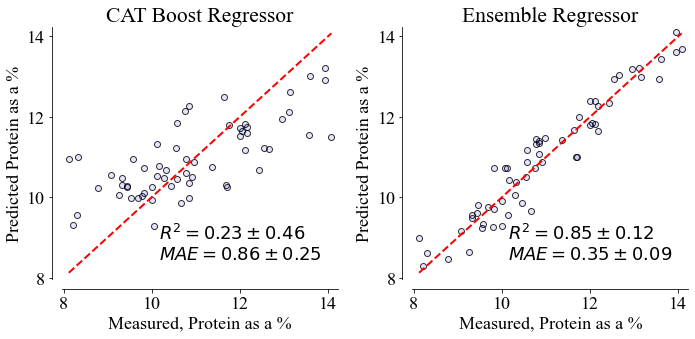

In [74]:
estimators = [('CAT Boost Regressor', CatBoostRegressor(logging_level='Silent',  eval_metric = 'MAE', depth=8))] 
stacking_regressor = StackingRegressor(estimators=estimators, passthrough= True, final_estimator=PLSRegression(n_components=12 ,copy=True, scale=True)) 

# estimators defined previously 
#evaluate_model(estimators, 'estimator')

def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, facecolor=(0,0,1,.1), edgecolor=(0,0,0,.8)) # alpha=0.2, edgecolors='b' 

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min()-.15, y_true.max()+.15])
    ax.set_ylim([y_true.min()-.15, y_true.max()+.15])
    ax.set_xlabel("Measured, Protein as a %", fontsize=18)
    ax.set_ylabel("Predicted Protein as a %", fontsize=18)
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
    ax.legend([extra], [scores], loc="lower right", frameon=False)
    title = title #+ "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = np.ravel(axs)
font = {'family' : 'Times New Roman',
            'size'   : 18}
plt.rc('font', **font)

for ax, (name, est) in zip(axs, estimators + [('Ensemble Regressor', stacking_regressor)]): 
    start_time = time.time()
    score = cross_validate(est, X_test, y_test, scoring=["r2", "neg_mean_absolute_error"], cv=cv, n_jobs=-1, verbose=0) # added CV to this line
    elapsed_time = time.time() - start_time
    y_pred = cross_val_predict(est, X_test, y_test, n_jobs=-1, verbose=0, cv=cv) # added CV to this line, maybe this should be on the

    plot_regression_results(ax,y_test,y_pred, name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),
        elapsed_time,
    )

#plt.suptitle("Ensemble Model, Performance of Estimator and Ensemble")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('ensemble_predictors.png', dpi=200, bbox_inches='tight') 
plt.show()

In [26]:
print('Ensemble R-squared:', stacking_regressor.fit(X_train, y_train).score(X_test, y_test))
print('PLS R-squared', PLSRegression(**params_PLS_gs.best_params_).fit(X_train, y_train).score(X_test, y_test))

Ensemble R-squared: 0.941981905599822
PLS R-squared 0.9297046028368441


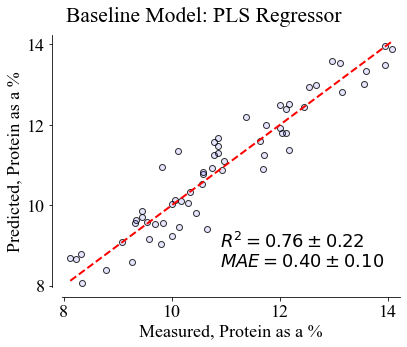

In [69]:
# Plot PLS only
estimators = [('PLS Regressor', PLSRegression(**params_PLS_gs.best_params_) )]
#evaluate_model_no_ensemble(estimators, 'estimator')

font = {'family' : 'Times New Roman',
            'size'   : 18}

def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, facecolor=(0,0,1,.1), edgecolor=(0,0,0,.8)) # alpha=0.2, edgecolors='b' 

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min()-.15, y_true.max()+.15])
    ax.set_ylim([y_true.min()-.15, y_true.max()+.15])
    ax.set_xlabel("Measured, Protein as a %", fontsize=18)
    ax.set_ylabel("Predicted Protein as a %", fontsize=18)
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
    ax.legend([extra], [scores], loc="lower right", frameon=False)
#    title = "\n Evaluation in {:.2f} seconds".format(elapsed_time) #title + 
#    ax.set_title(title)
  

fig, axs = plt.subplots(1, 1, figsize=(6,5))
axs = np.ravel(axs)
font = {'family' : 'Times New Roman',
            'size'   : 18}
plt.rc('font', **font)

for ax, (name, est) in zip(axs, estimators): 
    start_time = time.time()
    score = cross_validate(est, X_test, y_test, scoring=["r2", "neg_mean_absolute_error"], cv=cv, n_jobs=-1, verbose=0) 
    elapsed_time = time.time() - start_time
    y_pred = cross_val_predict(est, X_test, y_test, n_jobs=-1, verbose=0, cv=cv) 

    plot_regression_results(ax,y_test,y_pred, name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),
        elapsed_time,
    )

plt.suptitle("Baseline Model: PLS Regressor")
plt.tight_layout()
plt.subplots_adjust(top=.9)
plt.savefig('base_model.png', dpi=200, bbox_inches='tight') 
plt.show()

**Stratisfied Evaluation**

In [143]:
# Have to Drop the index before merging
y_stratified_test = pd.DataFrame(y_test.reset_index()).drop(columns=['index'])
x_stratified_test = pd.DataFrame(X_test.reset_index()).drop(columns=['index'])
stratified_testing = pd.concat([y_stratified_test, x_stratified_test], axis=1)

stratified_testing.PC.describe()

count    61.000000
mean     10.906721
std       1.527241
min       8.120000
25%       9.820000
50%      10.750000
75%      12.040000
max      14.080000
Name: PC, dtype: float64

In [164]:
stratified_testing

,PC,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,quantile
0,10.45,1.488537,1.374911,1.213075,-0.015803,-0.105277,-0.211391,-0.329271,-0.438662,-1.202965,...,0.269288,0.206730,0.085441,0.024972,-0.196285,-0.302661,-0.527226,-0.672913,-0.645807,"(9.82, 10.75]"
1,8.31,-0.050343,-0.038134,-0.036684,-0.000305,0.001979,0.005029,-0.004018,-0.003233,-0.091451,...,0.304651,0.317421,0.230911,0.175209,0.085712,0.165598,0.190289,0.202186,0.130569,"(9.82, 10.75]"
2,9.26,-0.887105,-0.861381,-0.848554,-0.419747,-0.351347,-0.291282,-0.216013,-0.162806,0.300143,...,0.066267,0.187132,0.272733,0.256770,0.103789,0.181485,0.482543,0.331616,0.285564,"(9.82, 10.75]"
3,10.92,0.343033,0.379569,0.360018,-0.007717,-0.020016,-0.048898,-0.076541,-0.082904,-0.187426,...,-0.443152,-0.466700,-0.651188,-0.713430,-0.704759,-0.713463,-0.419412,0.724493,0.843569,"(9.82, 10.75]"
4,13.94,-0.259729,-0.162417,0.062668,1.401737,1.492286,1.592436,1.709483,1.863663,2.483285,...,-0.441719,-0.257190,-0.106620,-0.001474,0.470862,0.767609,0.695983,-0.006168,-0.045181,"(9.82, 10.75]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,9.08,-1.753332,-1.747107,-1.726025,-0.803421,-0.741071,-0.682566,-0.641534,-0.558468,0.148284,...,2.113362,2.070443,1.894415,1.848463,1.942158,1.909591,1.528520,-0.927466,-1.084949,"(9.82, 10.75]"
57,8.12,-0.332127,-0.373149,-0.240108,2.013689,2.060277,2.104116,2.160669,2.166169,2.042370,...,-1.123709,-0.897127,-0.722291,-0.471436,0.227381,0.318314,0.412558,0.634385,0.739030,"(9.82, 10.75]"
58,13.56,0.706470,0.654686,0.640780,0.683127,0.690509,0.703979,0.707589,0.720102,0.555873,...,-0.422323,-0.506310,-0.457055,-0.462587,-0.410532,-0.267120,-0.140037,0.981896,1.025107,"(9.82, 10.75]"
59,12.00,-1.581341,-1.585116,-1.511828,0.103881,0.233738,0.361300,0.505327,0.673430,1.616836,...,1.576306,1.654585,1.648821,1.717582,1.951760,2.054772,2.122993,-0.416066,-0.665803,"(9.82, 10.75]"


In [222]:
# Create a column that has a quantile column to iloc everything with. This column will need to be deleted. 
stratified_testing['quantile']=pd.qcut(stratified_testing.PC, 3)
print(stratified_testing['quantile'].unique())
stratified_testing['quantile'].describe()

[(10.12, 11.69], (8.119, 10.12], (11.69, 14.08]]
Categories (3, interval[float64, right]): [(8.119, 10.12] < (10.12, 11.69] < (11.69, 14.08]]


count                 61
unique                 3
top       (8.119, 10.12]
freq                  21
Name: quantile, dtype: object

In [223]:
# Convert to string for calling below
stratified_testing['quantile']=stratified_testing['quantile'].astype(str)

Not enough data for 4 quantiles
q1= (stratified_testing.loc[stratified_testing['quantile'] == '(8.119, 9.82]']).drop(columns=['quantile'])
q2= (stratified_testing.loc[stratified_testing['quantile'] == '(9.82, 10.75]']).drop(columns=['quantile'])
q3= (stratified_testing.loc[stratified_testing['quantile'] == '(10.75, 12.04]']).drop(columns=['quantile'])
q4= (stratified_testing.loc[stratified_testing['quantile'] == '(12.04, 14.08]']).drop(columns=['quantile'])

In [232]:
q1= (stratified_testing.loc[stratified_testing['quantile'] == '(8.119, 10.12]']).drop(columns=['quantile'])
q2= (stratified_testing.loc[stratified_testing['quantile'] == '(10.12, 11.69]']).drop(columns=['quantile'])
q3= (stratified_testing.loc[stratified_testing['quantile'] == '(11.69, 14.08]']).drop(columns=['quantile'])

In [234]:
# Divide each into respective X, and y
# y = target values, last column of the data frame
X_q1 = q1.iloc[:, 1:]
y_q1 = q1.iloc[:, 0]

X_q2 = q2.iloc[:, 1:]
y_q2 = q2.iloc[:, 0]

X_q3 = q3.iloc[:, 1:]
y_q3 = q3.iloc[:, 0]

#X_q4 = q4.iloc[:, 1:]
#y_q4 = q4.iloc[:, 0]

In [226]:
def evaluate_model_stratisfied(estimators, string, y, x):
    X_test = x
    y_test = y
    score = {'NAME':[],'MSE':[], 'MSE STD':[], 'MAE':[], 'MAE STD':[],'Cross Validation Score':[],'R-Square':[], 'R-Square STD':[], 'Fit Time':[]} 

    for name, est in estimators+ [('Stacking Regressor', STACK_fit)]: 
   #     model=est.fit(X_train, y_train)
        model=est
        # evaluate the model and print the accuracies list
        cross_val = np.sqrt(-1*cross_val_score(model,X_test, y_test,cv=cv, scoring="neg_mean_absolute_error").mean())       
        scores = cross_validate(est, X_test, y_test, scoring=["r2", "neg_mean_absolute_error", "neg_mean_squared_error"], cv=10, n_jobs=-1, verbose=0) #added CV to this line
        score['NAME'].append(name)
        
        score['MSE'].append(-np.mean(scores['test_neg_mean_squared_error']))
        score['MSE STD'].append(np.std(scores['test_neg_mean_squared_error']))
        
        score['MAE'].append(-np.mean(scores['test_neg_mean_absolute_error']))
        score['MAE STD'].append(np.std(scores['test_neg_mean_absolute_error']))
        
        score['Cross Validation Score'].append(cross_val)
        
        score['R-Square'].append(np.mean(scores['test_r2']))
        score['R-Square STD'].append(np.std(scores['test_r2']))
        
        score['Fit Time'].append(np.mean(scores['fit_time']))
                            
    print(tabulate(score, headers=[string,'MSE', 'MSE STD','MAE', 'MAE STD', 'Cross Validation \n RSME', 'R-Square', 'R-Square STD', 'Fit Time']))

In [238]:
def evaluate_model_stratisfied_no_ensemble(estimators, string, y, x):
    X_test = x
    y_test = y
    score = {'NAME':[],'MSE':[], 'MSE STD':[], 'MAE':[], 'MAE STD':[],'Cross Validation Score':[],'R-Square':[], 'R-Square STD':[], 'Fit Time':[]} 

    for name, est in estimators: 
   #     model=est.fit(X_train, y_train)
        model=est
        # evaluate the model and print the accuracies list
        cross_val = np.sqrt(-1*cross_val_score(model,X_test, y_test,cv=cv, scoring="neg_mean_absolute_error").mean())       
        scores = cross_validate(est, X_test, y_test, scoring=["r2", "neg_mean_absolute_error", "neg_mean_squared_error"], cv=10, n_jobs=-1, verbose=0) #added CV to this line
        score['NAME'].append(name)
        
        score['MSE'].append(-np.mean(scores['test_neg_mean_squared_error']))
        score['MSE STD'].append(np.std(scores['test_neg_mean_squared_error']))
        
        score['MAE'].append(-np.mean(scores['test_neg_mean_absolute_error']))
        score['MAE STD'].append(np.std(scores['test_neg_mean_absolute_error']))
        
        score['Cross Validation Score'].append(cross_val)
        
        score['R-Square'].append(np.mean(scores['test_r2']))
        score['R-Square STD'].append(np.std(scores['test_r2']))
        
        score['Fit Time'].append(np.mean(scores['fit_time']))
                            
    print(tabulate(score, headers=[string,'MSE', 'MSE STD','MAE', 'MAE STD', 'Cross Validation \n RSME', 'R-Square', 'R-Square STD', 'Fit Time']))

In [267]:
# Fit once 
CAT = CatBoostRegressor(logging_level='Silent',  eval_metric = 'MAE', depth=8)
CAT_fit = CAT.fit(X_train, y_train)
estimators = [('CAT Boost Regressor', CAT_fit)] 

STACK = StackingRegressor(estimators=estimators, passthrough= True, final_estimator=PLSRegression(n_components=12 ,copy=True, scale=True)) 
STACK_fit = STACK.fit(X_train, y_train)

In [268]:
estimators = [('CAT Boost Regressor', CAT_fit)] 

# estimators defined previously 
evaluate_model_stratisfied(estimators, 'q1', y_q1, X_q1)
evaluate_model_stratisfied(estimators, 'q2', y_q2, X_q2)
evaluate_model_stratisfied(estimators, 'q3', y_q3, X_q3)

q1                        MSE    MSE STD       MAE    MAE STD    Cross Validation     R-Square    R-Square STD    Fit Time
                                                                              RSME
-------------------  --------  ---------  --------  ---------  -------------------  ----------  --------------  ----------
CAT Boost Regressor  0.459594   0.355988  0.523838   0.274703             0.723767    -120.286         342.036     10.0305
Stacking Regressor   0.657821   0.507751  0.670139   0.273621             0.81862     -156.94          458.343     26.9715
q2                        MSE    MSE STD       MAE    MAE STD    Cross Validation     R-Square    R-Square STD    Fit Time
                                                                              RSME
-------------------  --------  ---------  --------  ---------  -------------------  ----------  --------------  ----------
CAT Boost Regressor  0.194531   0.233681  0.315401   0.231607             0.561606    -11.6608  

In [239]:
PLS = PLSRegression(**params_PLS_gs.best_params_)
PLS_fit = PLS.fit(X_train, y_train)

estimators = [('PLS Regressor', PLS_fit)]

evaluate_model_stratisfied_no_ensemble(estimators, 'q1', y_q1, X_q1)
evaluate_model_stratisfied_no_ensemble(estimators, 'q2', y_q2, X_q2)
evaluate_model_stratisfied_no_ensemble(estimators, 'q3', y_q3, X_q3)

q1                 MSE    MSE STD       MAE    MAE STD    Cross Validation     R-Square    R-Square STD    Fit Time
                                                                       RSME
-------------  -------  ---------  --------  ---------  -------------------  ----------  --------------  ----------
PLS Regressor  1.75279    3.33449  0.864816   0.629986             0.929955    -652.619         1862.18    0.006303
q2                 MSE    MSE STD      MAE    MAE STD    Cross Validation     R-Square    R-Square STD    Fit Time
                                                                      RSME
-------------  -------  ---------  -------  ---------  -------------------  ----------  --------------  ----------
PLS Regressor  0.49456   0.574203  0.56955   0.324236             0.754685    -21.9326         18.8247  0.00680227
q3                  MSE    MSE STD       MAE    MAE STD    Cross Validation     R-Square    R-Square STD    Fit Time
                                       

In [269]:
stacking_regressor = StackingRegressor(estimators=estimators, passthrough= True, final_estimator=PLSRegression(n_components=12 ,copy=True, scale=True)) 
estimators = [('CAT Boost Regressor', CAT_fit)] 

y_pred = cross_val_predict(stacking_regressor, X_test, y_test, n_jobs=-1, verbose=0, cv=cv) 

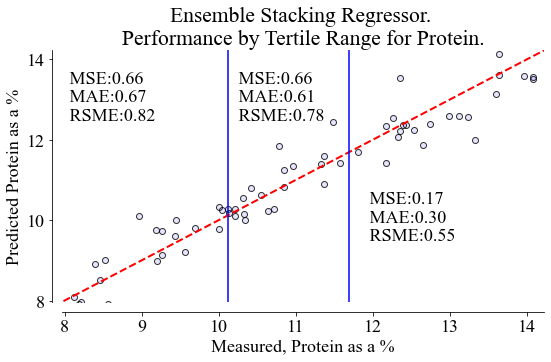

In [329]:
#estimators = [('CAT Boost Regressor', CatBoostRegressor(logging_level='Silent',  eval_metric = 'MAE', depth=8))] 
#evaluate_model_no_ensemble(estimators, 'estimator')

font = {'family' : 'Times New Roman',
            'size'   : 18}

def plot_regression_results(ax, y_true, y_pred, title):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [y_true.min()-.5, y_true.max()+.5], [y_true.min()-.5, y_true.max()+.5], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, facecolor=(0,0,1,.1), edgecolor=(0,0,0,.8)) # alpha=0.2, edgecolors='b' 

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min()-.15, y_true.max()+.15])
    ax.set_ylim([y_true.min()-.15, y_true.max()+.15])
    ax.set_xlabel("Measured, Protein as a %", fontsize=18)
    ax.set_ylabel("Predicted Protein as a %", fontsize=18)  

fig, axs = plt.subplots(1, 1, figsize=(8,5))
axs = np.ravel(axs)
font = {'family' : 'Times New Roman',
            'size'   : 18}
plt.rc('font', **font)

for ax, (name, est) in zip(axs, estimators): 
    plot_regression_results(ax,y_test,y_pred, name )

xcoords = [10.12, 11.69]

plt.annotate(' MSE:0.66 \n MAE:0.67 \n RSME:0.82 ',xy=(8,12.5))
plt.annotate(' MSE:0.66 \n MAE:0.61 \n RSME:0.78 ',xy=(10.2,12.5))
plt.annotate(' MSE:0.17 \n MAE:0.30\n RSME:0.55 ',xy=(11.9,9.5))

#[(10.12, 11.69], (8.119, 10.12], (11.69, 14.08]]
plt.axvline(x=10.12,  c='b')
plt.axvline(x=11.69,  c='b')          
    
plt.title("Ensemble Stacking Regressor. \nPerformance by Tertile Range for Protein.")
plt.tight_layout()
plt.subplots_adjust(top=.9)
plt.savefig('base_model.png', dpi=700, bbox_inches='tight') 
plt.show()